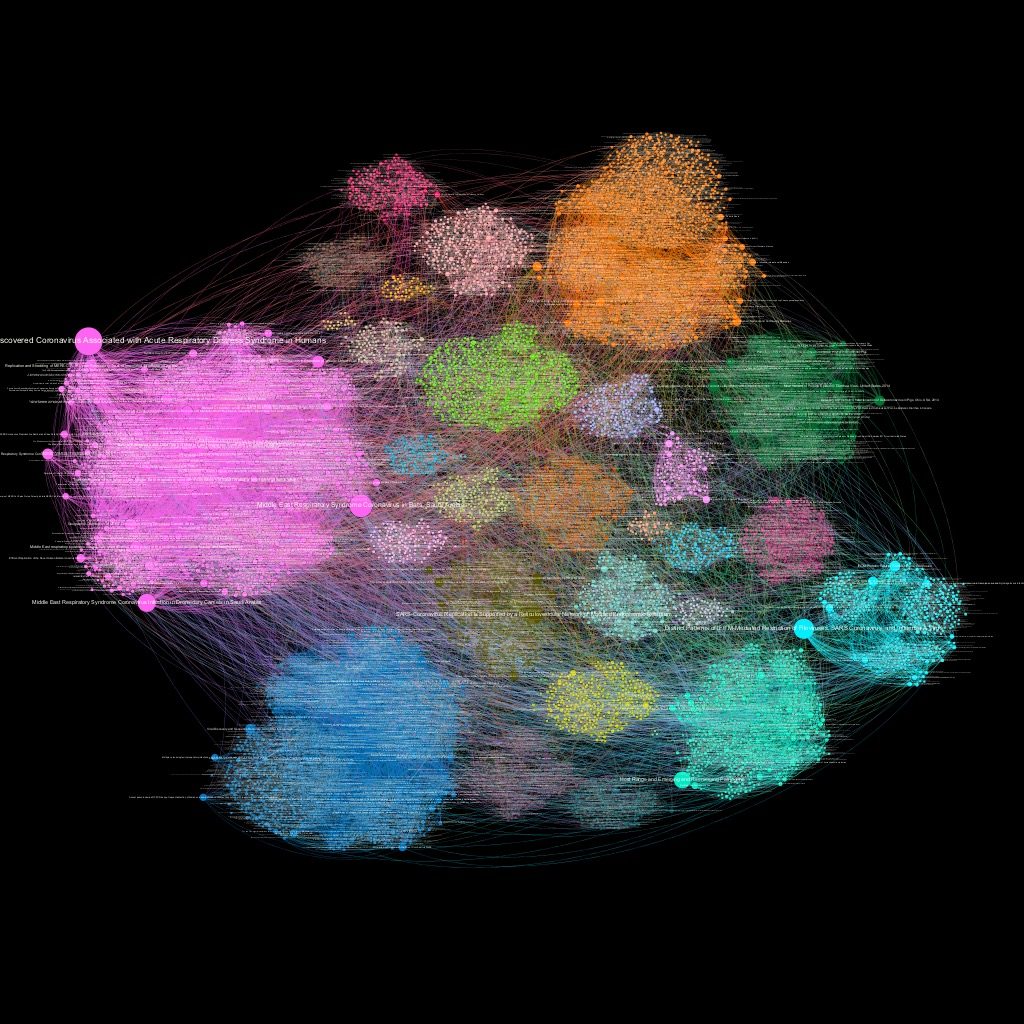

# A references-based atlas of COVID-19 research
We have a massive set of articles. I want to create a map of them. One way to organise this map is through references: these articles will cite each other and will have common references as well. References will correlate strongly with the content. Hence, structuring the map using the web of references might help to organise of this huge body of literature.

The interactive map (the final result) can be found here: https://moritzmoeller.github.io/covid-19-literature-atlas/

You can:
* get an idea of the global picture of the dataset
* look at article titles by hovering over nodes
* explore the publications referenced in articles by clicking on nodes
* search for articles by name

Below, I'll show how to get and process the data to the point where all is put together in a graph. The layout and visualisition is done in Gephi. I describe the steps I have taken there, but there is no code to provide as I used the GUI to arrive at the final result.

## Load data
For now, I'll only use metadata for this. I get my reference data from PubMed, so I discard all articles without Pubmed ID. I'll get rid of duplicates, too.

In [ ]:
import pandas as pd

df = pd.read_csv('../input/CORD-19-research-challenge/metadata.csv')
df.dropna(subset=['pubmed_id'], inplace=True)
df.drop_duplicates(subset="pubmed_id", keep=False, inplace=True)
df.info()

## Connect to PubMed
I use the Bio API and an account I made for this purpose to connect to PubMed. This will allow me to query citation data.

In [ ]:
from Bio import Entrez

Entrez.api_key = '14e49850c0c543c6475d9a78943173bc8508'
Entrez.email = 'pubmed.query@gmail.com'

## Get citation data
For each article, I retrieve the PubMed IDs of the articles on its reference list. This is done in batches of 100 articles at a time.

In [ ]:
refs = []
allids = [int(id) for id in df['pubmed_id'].tolist()]
idbatches = [allids[x:x+100] for x in range(0, len(allids), 100)]
for i, ids in enumerate(idbatches):
    print('Processing batch %i' % i)
    handle = Entrez.elink(dbfrom='pubmed', id=ids, linkname='pubmed_pubmed_refs')
    results = Entrez.read(handle)
    
    for res in results:
        if res["LinkSetDb"] == []:
            pmids = []
        else:
            pmids = [int(link["Id"]) for link in res["LinkSetDb"][0]["Link"]]
        refs.append(pmids)
        
df['refs'] = refs
allrefs = [ref for reflist in df['refs'].tolist() for ref in reflist] # might contain duplicates

Alright, we got the references. There is a little more processing to do before drawing, in order to keep the number of vertices in the final graph as low as possible. If there are too many, layout and drawing will take forever.

## Find shared references
Out of all references, I am only interested in two types:
1. Crossreferences between articles in our data set
2. References that occur in more than one reference list, which I refer to as shared references

Next, I'll find those shared references. First, get a list of them:

In [ ]:
seen = {}
commonrefs = []

for x in allrefs:
    if x not in seen:
        seen[x] = 1
    else:
        if seen[x] == 1:
            commonrefs.append(x)
        seen[x] += 1
print('There are %i refs that occur more than once.' % len(commonrefs))

Then, get a list of shared or cross references for each article in our data set (we throw away the references that are only cited in one article, since they won't help us with the atlas).

In [ ]:
shared = []
cross = {id:1 for id in allids}
for index, row in df.iterrows():
    sharedrefs = [ref for ref in row['refs'] if seen[ref] > 1 or ref in cross]
    shared.append(sharedrefs)

I then add the lists of shared references to the dataframe. I drop articles that are not connected to any of them.

In [ ]:
df['sharedrefs'] = shared
df['nsharedrefs'] = df['sharedrefs'].apply(lambda x: len(x))
df = df[df['nsharedrefs'] > 0]

Now, we have our reference data. The last bit of this will be to visualise it. 

## Export for Gephi
To visualise the atlas of publications and the references between them, I'll use Gephi (https://gephi.org). It allows to run some graph analyses useful for finding clusters, as well as layouts and drawing. To do all this, I need to export a list of nodes (those will be the publications, both from the dataset and from the shared references) and a list of edges (those are the references, i.e. there should be an edge between two publications if one of them references the other).

First, create the node list. For each node, I supply a PubMed ID, the title of the publication and whether or not is is in the dataset. I create a table containing those things and save it as *.csv. It is important to have one column called Id and one called Label.

In [ ]:
nodes = allids + commonrefs
node_types = [1 for pub in allids] + [0 for ref in commonrefs]
node_titles = [title for title in df['title'].tolist()] + ['' for ref in commonrefs]
df_nodes = pd.DataFrame(list(zip(nodes, node_types, node_titles)), columns =['Id', 'Type', 'Label'])
df_nodes.to_csv('nodes.csv', index=False)  

Then, I create the edge list, and also save it as *csv. It is important to have one column called Source and one called Target. In Gephi, the Id of nodes will be identified with the entries in Source and Target.

In [ ]:
sources = []
targets = []
for _,row in df.iterrows():
    source = int(row['pubmed_id'])
    for ref in row['sharedrefs']:
        target = ref
        sources.append(source)
        targets.append(target)
        
df_edges = pd.DataFrame(list(zip(sources, targets)), columns =['Source', 'Target'])
df_edges.to_csv('edges.csv', index=False)  

This is the data part done. The rest is done with Gephi. I pretty much follow this tutorial [here](http://blog.miz.space/tutorial/2020/01/05/gephi-tutorial-sigma-js-plugin-publishing-interactive-graph-online/), and publish the result here: https://moritzmoeller.github.io/covid-19-literature-atlas/. The main steps are:
* Use Gephi's Modularity feature to partion nodes into communities (tighly connected subgraphs). This gives a partion.
* Use this partion as first and number of incoming edges as second feature for the Circle Pack layout to obtain a nice map.
* Make nodes and edges of shared references invisible (we only care about the present dataset for now)
* Use number of citations to determine the size of the nodes (i.e. articles that are referenced often will be big)
* Export a SigmaJS template using the respective plugin, and publish through GitHub.

## A comment on the final map
The final map only shows the references that are in the dataset. However, both layout and partioning have included the common references as well. This should give a robust clustering. A different variation of this analysis would be to create this map only based on crossreferences within this dataset. Another intersting thing might be to introduce a publication date somehow and turn this into more of a familiy tree.